In [1]:
from networks.network3d import CNN_240p_Denoiser_Expanded_3d
from data import load_data
import torch
from torch.utils.tensorboard import SummaryWriter
import argparse
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from inputimeout import inputimeout, TimeoutOccurred
from utils import *

In [2]:
def load_model_from_path( path, device):
    model_name = path
    network = load_model(model_type=CNN_240p_Denoiser_Expanded_3d, model_name=model_name)
    network.to(device)
    return network

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
network = load_model_from_path(f'/workspace/experiments/CNN_DENOISER_EXPANDED_LONG/cnn_240p_den_v_bn_0', device) 

In [5]:
val_data = load_data(os.path.join('/workspace/CNN_240p_Denoiser', 'val'), batch_size=8, num_workers=10, num_dataset_threads=1, data_count=2000)

Loading /workspace/CNN_240p_Denoiser/val on 1 threads
Thread started


CNN_240p_Denoiser-val-(0, 2000): 100%|██████████| 2000/2000 [00:02<00:00, 995.49it/s, image=['CNN_240_Denoiser-albedo-999.jpg', 'CNN_240_Denoiser-converged-999.jpg', 'CNN_240_Denoiser-depth-999.jpg', 'CNN_240_Denoiser-emission-999.jpg', 'CNN_240_Denoiser-extcoMetal-999.jpg', 'CNN_240_Denoiser-ior-999.jpg', 'CNN_240_Denoiser-k-999.jpg', 'CNN_240_Denoiser-noisy-999.jpg', 'CNN_240_Denoiser-normals-999.jpg', 'CNN_240_Denoiser-roughSmooth-999.jpg', 'CNN_240_Denoiser-shape-999.jpg', 'CNN_240_Denoiser-specular-999.jpg']]            


In [6]:
def validate(network, val_data, device):
    loss = torch.nn.MSELoss()
    total_val_loss = 0
    network.eval()
    debug_images = None
    count = 0
    with tqdm(iter(val_data), unit="batches") as valloop:
        for i, buffers in enumerate(valloop):
            count += 1
            # self.loss_plotter.update_display()
            valloop.set_description(f"Val Batch {i}")
            input_tensor = network.make_input_tensor(buffers).to(device)
            ground_truth = buffers['converged'][:, :, None, :, :].to(device)
            res = network(input_tensor)
            if (i == 0):
                debug_images = buffers['noisy'][:8, :, :, :], ground_truth[:8, :, 0, :, :], res[:8, :, :, :]
                pass
            input_tensor = input_tensor.detach()
            del input_tensor
            l = loss(res, ground_truth[:,:,0,:,:])
            ground_truth = ground_truth.detach()
            del ground_truth
            curr_loss = l.cpu().data
            total_val_loss += curr_loss
            valloop.set_postfix(loss=f"{curr_loss}")
    return total_val_loss / count, debug_images

In [7]:
loss, debug_images = validate(network, val_data, device)

Val Batch 249: 100%|██████████| 250/250 [00:39<00:00,  6.32batches/s, loss=0.00676646176725626]  


In [8]:
import torchvision
def show_images(res):
    grid_img = torchvision.utils.make_grid(res, nrow=5)
    plt.imshow(grid_img.permute(1, 2, 0))

In [9]:
def record_imgs(noisy, tru, pred):
    print(tru.shape)
    assert len(tru.shape) == 4
    assert tru.shape == pred.shape
    final = torch.zeros(3 * tru.shape[0], tru.shape[1], tru.shape[2], tru.shape[3])
    j = 0
    for i in range(tru.shape[0]):
        final[j] = noisy[i]
        final[j+1] = tru[i]
        final[j+2] = pred[i]
        j += 3
    return final

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 240, 426])
torch.Size([24, 3, 240, 426])


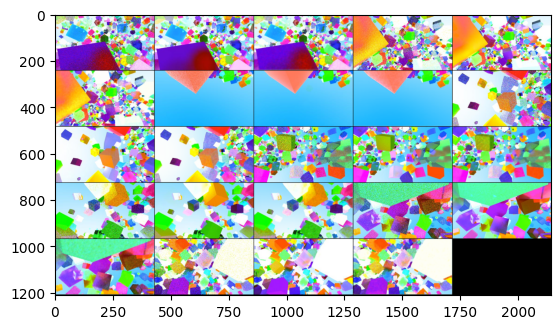

In [10]:
recorded_images = record_imgs(debug_images[0].detach().cpu(), debug_images[1].detach().cpu(), debug_images[2].detach().cpu())
print(recorded_images.shape)

show_images(recorded_images)

In [11]:
from torchvision.utils import save_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Pred


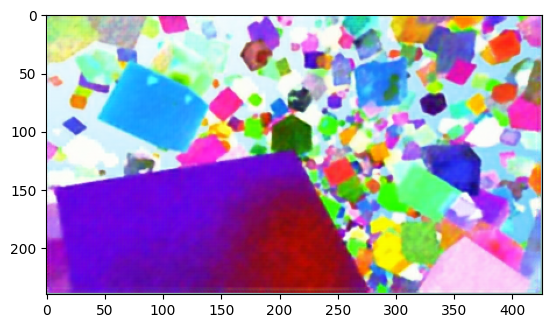

In [14]:
plt.imshow(debug_images[2].detach().cpu()[0].permute(1, 2, 0))
print("Pred")

noisy


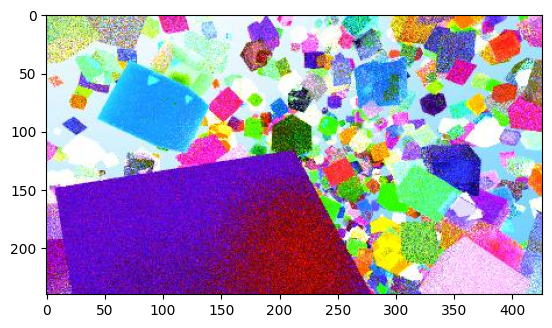

In [16]:
plt.imshow(debug_images[0].detach().cpu()[0].permute(1, 2, 0))
print('noisy')

converged


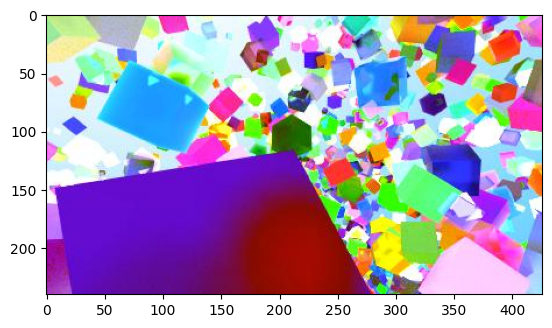

In [17]:
plt.imshow(debug_images[1].detach().cpu()[0].permute(1, 2, 0))
print('converged')

In [ ]:
save_image(img1, 'img1.png')